In [1]:
# Sampurna Mukherjee, May 2023

In [ ]:
#activate GROMACS first 

source /hps/software/users/chembl/sampurnam/bin/GMXRC

In [2]:
%ls *.pdb

6id4_modeller_fixed.pdb  6id4_with_crystal_water_mol_probity.pdb


# Step1: pdb2gmx

gmx_mpi pdb2gmx -f 6id4_with_crystal_water_mol_probity.pdb -o 6id4_crys_water_protonated_pdb2gmx.gro -water tip3p -p 6id4_crys_water_protonated_pdb2gmx.top -ignh

# Net charge of system : -3 e

# The top file will be used all through simulation : 6id4_crys_water_protonated_pdb2gmx.top

# Step 2: Copy topology file after pdb2gmx

In [4]:
%cp 6id4_crys_water_protonated_pdb2gmx.top a1101_pbd2gmx.top

# Step 3: copy .itp file for water from gromacs folder to current folder and rename it


In [5]:
%cp tip3p.itp .

In [6]:
#renaming it
%mv tip3p.itp crys_water.itp

# Step 4: Edit  6id4_crys_water_protonated_pdb2gmx.top file in vi.
# Add:
; Include crys_water topology
#include "crys_water.itp"


# Make sure that position restraint for water in uncommented like below

#ifdef POSRES_WATER
; Position restraint for each water oxygen
[ position_restraints ]
;  i funct       fcx        fcy        fcz
   1    1       1000       1000       1000
#endif


; Include topology for ions
#include "amber99sb.ff/ions.itp"

# Change SOL to crys_water in .top and in crys_water.itp file

In [9]:
#%cat 6id4_crys_water_protonated_pdb2gmx.top

In [10]:
#%cat crys_water.itp

# Step 5: Copy the changed files to keep a backup


In [11]:
%cp 6id4_crys_water_protonated_pdb2gmx.top edited_with_crys_water_config_pbd2gmx.top

In [12]:
%cp crys_water.itp edited_with_CRYS_for_crys_water.itp

# Step 6 : Generate box

In [ ]:
gmx_mpi editconf -f 6id4_crys_water_protonated_pdb2gmx.gro  -o a1101_crys_water_editconf_box.gro -bt cubic -c -d 1.8

# Visualize the pdb2gmx file and box to see if all look okay

In [15]:
import nglview as ng
#view_pdb2gmx = ng.show_file("6id4_crys_water_protonated_pdb2gmx.gro")
#view_pdb2gmx.add_line("water")
#view_pdb2gmx

view_box = ng.show_file("a1101_crys_water_editconf_box.gro")
view_box

NGLWidget()

# Step 7: Solvate
gmx_mpi solvate -cp a1101_crys_water_editconf_box.gro  -cs spc216.gro -o 6id4_crys_water_run1_solvated.gro -p 6id4_crys_water_protonated_pdb2gmx.top


In [18]:
#Renaming the outfile 
%mv 6id4_crys_water_run1_solvated.gro a1101_crys_water_solvated.gro

In [16]:
#Copy the top file
%cp 6id4_crys_water_protonated_pdb2gmx.top a1101_after_solvation.top

In [20]:
# Visualize solvated box
#view_solvated = ng.show_file("a1101_crys_water_solvated.gro")
#view_solvated.add_line("water")
#view_solvated

NGLWidget()

# Step 8: Create ions.mdp, change ions.mdp to constrain hydrogens and use PME instead of plain Coulomb cutoff

# Contents of ions.mdp, copied from http://www.mdtutorials.com/gmx/lysozyme/Files/ions.mdp
; ions.mdp - used as input into grompp to generate ions.tpr
; Parameters describing what to do, when to stop and what to save
integrator  = steep         ; Algorithm (steep = steepest descent minimization)
emtol       = 1000.0        ; Stop minimization when the maximum force < 1000.0 kJ/mol/nm
emstep      = 0.01          ; Minimization step size
nsteps      = 50000         ; Maximum number of (minimization) steps to perform

; Parameters describing how to find the neighbors of each atom and how to calculate the interactions
nstlist         = 1         ; Frequency to update the neighbor list and long range forces
cutoff-scheme	= Verlet    ; Buffered neighbor searching 
ns_type         = grid      ; Method to determine neighbor list (simple, grid)
coulombtype     = cutoff    ; Treatment of long range electrostatic interactions
rcoulomb        = 1.0       ; Short-range electrostatic cut-off
rvdw            = 1.0       ; Short-range Van der Waals cut-off
pbc             = xyz       ; Periodic Boundary Conditions in all 3 dimensions

# Change coulombtype=PME, nstlist = 20, add constraint-algorithm lincs constraints             = h-bonds  ; bonds involving H are constrained

In [1]:
#touch ion_crys_water.mdp

UsageError: Line magic function `%touch` not found.


In [3]:
%cat ion_crys_water.mdp

; ions.mdp - used as input into grompp to generate ions.tpr
; Parameters describing what to do, when to stop and what to save
integrator  = steep         ; Algorithm (steep = steepest descent minimization)
emtol       = 1000.0        ; Stop minimization when the maximum force < 1000.0 kJ/mol/nm
emstep      = 0.01          ; Minimization step size
nsteps      = 50000         ; Maximum number of (minimization) steps to perform

; Parameters describing how to find the neighbors of each atom and how to calculate the interactions
constraints     = h-bonds   ; bonds involving H are constrained
constraint_algorithm = lincs ;
nstlist         = 20        ; Frequency to update the neighbor list and long range forces
cutoff-scheme	= Verlet    ; Buffered neighbor searching 
ns_type         = grid      ; Method to determine neighbor list (simple, grid)
coulombtype     = PME       ; Treatment of long range electrostatic interactions
rcoulomb        = 1.0       ; Short-range electrostatic cut-off
rvd

gmx_mpi grompp -f ion_crys_water.mdp -c a1101_crys_water_solvated.gro -p 6id4_crys_water_protonated_pdb2gmx.top -o a1101_crys_water_ionization.tpr -maxwarn =1

In [4]:
#Copying the mdp file
%cp ion_crys_water.mdp ion_crys_water_copy.mdp

In [5]:
#Copyin the top file
%cp 6id4_crys_water_protonated_pdb2gmx.top a1101_crys_water_after_ions_tpr.top

# Step 9: Run ionization

gmx_mpi genion -s a1101_crys_water_ionization.tpr  -o a1101_crys_water_ionized.gro -conc 0.15 -p 6id4_crys_water_protonated_pdb2gmx.top  -pname NA -nname CL -neutral
# Chose 13 : SOL to be replaced with ions

In [8]:
#copy top file
%cp 6id4_crys_water_protonated_pdb2gmx.top a1101_crys_water_after_ionization_done.top

In [1]:
%pwd

'/nfs/production/arl/sampurna_thesis/a1101_crystal_water'

# Step 10: Run energy minization 

In [6]:
%ls *.mdp

em_steepest_descent.mdp  ion_crys_water.mdp  md_6id4.mdp  npt_6id4.mdp
ion_crys_water_copy.mdp  ions.mdp            mdout.mdp    nvt_6id4.mdp


In [7]:
%cat em_steepest_descent.mdp

integrator               = steep
emtol                    = 1000.0 ; Stop minimization when the maximum force < 500.0 kJ/mol/nm
emstep                   = 0.01
nsteps                   = 5000


; Parameters describing how to find the neighbors of each atom and how to calculate the interactions
nstlist         = 10        ; Frequency to update the neighbor list and long range forces
cutoff-scheme   = Verlet    ; Buffered neighbor searching
ns_type         = grid      ; Method to determine neighbor list (simple, grid)
coulombtype     = PME       ; Treatment of long range electrostatic interactions
rcoulomb        = 1.0       ; Short-range electrostatic cut-off
rvdw            = 1.0       ; Short-range Van der Waals cut-off
pbc             = xyz       ; Periodic Boundary Conditions in all 3 dimensions



### Modify crys_water itp file
Because we are retaining crystal waters in the simulation

In [ ]:
%cp crys_water.itp crys_water_unconstrained.itp

In [ ]:
!vi crys_water.itp

##
( https://gromacs.bioexcel.eu/t/how-to-treat-specific-water-molecules-as-ligand/3470/5)

replace [settles] in crys_water.itp with 

[ constraints ]
1 2 1 0.09572
1 3 1 0.09572
2 3 1 0.15139

In [5]:
%cat crys_water.itp

[ moleculetype ]
; molname	nrexcl
crys_water	2

[ atoms ]
; id  at type     res nr  res name  at name  cg nr  charge    mass
  1   OW          1       SOL       OW       1      -0.834    16.00000
  2   HW          1       SOL       HW1      1       0.417     1.00800
  3   HW          1       SOL       HW2      1       0.417     1.00800

#ifndef FLEXIBLE

[ constraints ]
1 2 1 0.09572
1 3 1 0.09572
2 3 1 0.15139

[ exclusions ]
1	2	3
2	1	3
3	1	2

#else

[ bonds ]
; i     j       funct   length  force_constant
1       2       1       0.09572 502416.0   0.09572        502416.0 
1       3       1       0.09572 502416.0   0.09572        502416.0 
        

[ angles ]
; i     j       k       funct   angle   force_constant
2       1       3       1       104.52  628.02      104.52  628.02  

#endif


# Step 10.1: generate em.tpr

In [ ]:

gmx_mpi grompp -f em_steepest_descent.mdp -c a1101_crys_water_ionized.gro  -p 6id4_crys_water_protonated_pdb2gmx.top -o em_a1101_crys_water_steepest_descent.tpr

In [9]:
#copy the top file
%cp 6id4_crys_water_protonated_pdb2gmx.top a1101_em_tpr.top

# Request resources from SLURM cluster for mdrun: 
salloc -t 1:30:00 --mem=5G --gpus=v100:1

In [ ]:
#run mdrun
gmx_mpi mdrun -deffnm em_a1101_crys_water_steepest_descent -s em_a1101_crys_water_steepest_descent.tpr -nb gpu

# Step 10.3 : Create and visualize the energy file to observe if the system is stable or not

gmx_mpi energy -f em_a1101_crys_water_steepest_descent.edr -o a1101_crys_water_steepest_descent_potential.xvg -xvg none (choose 10 0)

In [13]:
import plotly
import plotly.graph_objs as go

# Read data from file and filter energy values higher than 1000 Kj/mol^-1
with open('a1101_crys_water_steepest_descent_potential.xvg','r') as energy_file:
    x,y = map(
        list,
        zip(*[
            (float(line.split()[0]),float(line.split()[1]))
            for line in energy_file 
            if not line.startswith(("#","@")) 
            if float(line.split()[1]) < 1000 
        ])
    )

plotly.offline.init_notebook_mode(connected=True)

fig = ({
    "data": [go.Scatter(x=x, y=y)],
    "layout": go.Layout(title="Energy Minimization",
                        xaxis=dict(title = "Energy Minimization Step"),
                        yaxis=dict(title = "Potential Energy KJ/mol-1")
                       )
})

plotly.offline.iplot(fig)

# Step 11.1: Modify nvt.mdp file

In [17]:
%ls *.mdp

em_steepest_descent.mdp  ion_crys_water.mdp  md_6id4.mdp  npt_6id4.mdp
ion_crys_water_copy.mdp  ions.mdp            mdout.mdp    nvt_6id4.mdp


In [18]:
%cat nvt_6id4.mdp

title                   = 6id4 equilibration 
define                  = -DPOSRES  ; position restrain the protein

; Parameters describing what to do, when to stop and what to save
integrator              = md        ; leap-frog integrator
dt                      = 0.002     ; 2 fs
nsteps                  = 500000     ; 2 * 500000 = 1000 ps= 1ns
nstenergy               = 500       ; save energy and temperature every 1.0 ps

; periodic boundary condition
pbc                     = xyz       ;

; Keep system temperature fluctuating physically correct
tcoupl                  = V-rescale           ; modified Berendsen thermostat
tc-grps                 = Protein SOL Ion   ; coupling groups 
tau_t                   = 0.1      0.1 0.1    ; time constant, in ps
ref_t                   = 300      300 300; reference temperature, one for each group, in K

; Pressure coupling is off
pcoupl                  = no

; Velocity generation
gen_vel                 = yes                 ; assign velocitie

In [19]:
%cat 6id4_crys_water_protonated_pdb2gmx.top

;
;	File '6id4_crys_water_protonated_pdb2gmx.top' was generated
;	By user: sampurna (8231)
;	On host: codon-slurm-login-02.ebi.ac.uk
;	At date: Tue May 16 18:03:23 2023
;
;	This is a standalone topology file
;
;	Created by:
;	                     :-) GROMACS - gmx pdb2gmx, 2022 (-:
;	
;	Executable:   /hps/software/users/chembl/sampurnam/bin/gmx_mpi
;	Data prefix:  /hps/software/users/chembl/sampurnam
;	Working dir:  /hps/software/users/chembl/sampurnam/sims_02_05_2023/6id4_plain/a1101_crystal_water
;	Command line:
;	  gmx_mpi pdb2gmx -f 6id4_with_crystal_water_mol_probity.pdb -o 6id4_crys_water_protonated_pdb2gmx.gro -water tip3p -p 6id4_crys_water_protonated_pdb2gmx.top -ignh
;	Force field was read from the standard GROMACS share directory.
;

; Include forcefield parameters
#include "amber99sb.ff/forcefield.itp"

; Include chain topologies
#include "6id4_crys_water_protonated_pdb2gmx_Protein_chain_A.itp"
#include "6id4_crys_water_protonated_pdb2gmx_Protein_chain_B.itp"
#include "6id4

In [20]:
#copy top file
%cp 6id4_crys_water_protonated_pdb2gmx.top a1101_water_after_em.top

# Change
- vdwtype = coulomb to PME
- do not add crys_water in tc-groups
- add tau-t and ref-t values to be same as others accordingly
- vdwtype = PME
-  rvdw = 0.9
-   vdw-modifier = Potential-Shift
-    rlist = 0.9
- rcoulomb = 0.9
-  fourierspacing = 0.12
-  pme-order = 4
-  ewald-rtol-lj = 0.001
-   lj-pme-comb-rule = geometric
-   DispCorr = EnerPres
-   save coordinates very 10 ps instead of 1 ps


In [21]:
%cp nvt_6id4.mdp a1101_water_nvt.mdp

In [ ]:
#vi a1101_water_nvt.mdp

In [ ]:
%cp a1101_water_nvt.mdp a1101_tc_grp_removed.mdp

In [30]:
%cat a1101_tc_grp_removed.mdp

title                   = 6id4 equilibration NVT
define                  = -DPOSRES  ; position restrain the protein

; Parameters describing what to do, when to stop and what to save
integrator              = md        ; leap-frog integrator
dt                      = 0.002     ; 2 fs
nsteps                  = 500000     ; 2 * 500000 = 1000 ps= 1ns
nstenergy               = 500       ; save energy and temperature every 1.0 ps

; periodic boundary condition
pbc                     = xyz       ;

; Keep system temperature fluctuating physically correct
tcoupl                  = V-rescale           ; modified Berendsen thermostat
tc-grps                 = Protein SOL Ion  ; coupling groups 
tau_t                   = 0.1      0.1 0.1     ; time constant, in ps
ref_t                   = 300      300 300 ; reference temperature, one for each group, in K

; Pressure coupling is off
pcoupl                  = no

; Velocity generation
gen_vel                 = yes                 ; assign veloc

In [2]:
#%cat crys_water.itp

# Step 11.2: Create the nvt.tpr

In [ ]:
#first, create an  index file with protein and water groups

gmx_mpi make_ndx -f em_a1101_crys_water_steepest_descent.gro -o a1101_water_post_em.ndx

In [ ]:
#Running grompp for nvt.tpr
gmx_mpi grompp -f a1101_tc_grp_removed.mdp -c em_a1101_crys_water_steepest_descent.gro -r em_a1101_crys_water_steepest_descent.gro -p 6id4_crys_water_protonated_pdb2gmx.top -o a1101_water_nvt.tpr -n a1101_water_post_em.ndx

# Step 11.3: NVT MDrun using sbatch in SLURM cluster

In [ ]:
sbatch --mem=100G --time=08:00:00 -c 12 --gpus=v100:1 --wrap="gmx_mpi mdrun -deffnm a1101_crys_w
ater_nvt_with_batch_file -s a1101_water_pme_fixed_nvt_with_batch_file.tpr -nb gpu -ntomp 12"

In [ ]:
%cat a1101_crys_water_nvt_with_batch_file.log

# Step 11.4 : Visualize temperature change during NVT


gmx_mpi energy -f a1101_crys_water_nvt_with_batch_file.edr -o a1101_crys_water_nvt_temperature.xvg -xvg none (then 17 0)

In [1]:
import plotly
import plotly.graph_objs as go
import pandas as pd
import Bio
import numpy as np

# Read temperature data from file 
with open('a1101_crys_water_nvt_temperature.xvg','r') as temperature_file:
    x,y = map(
        list,
        zip(*[
            (float(line.split()[0]),float(line.split()[1]))
            for line in temperature_file 
            if not line.startswith(("#","@")) 
        ])
    )

plotly.offline.init_notebook_mode(connected=True)

fig = {
    "data": [go.Scatter(x=x, y=y)],
    "layout": go.Layout(title="Temperature during NVT Equilibration",
                        xaxis=dict(title = "Time (ps)"),
                        yaxis=dict(title = "Temperature (K)")
                       )
}

plotly.offline.iplot(fig)

# Step 11.5 :NPT
# Edit NPT.mdp file, create .tpr file, mdrun using sbatch script

In [4]:
#copying the previous top file
%cp 6id4_crys_water_protonated_pdb2gmx.top a1101_after_nvt.top

In [5]:
#renaming the topology file
%mv 6id4_crys_water_protonated_pdb2gmx.top a1101_water.top

# NPT.mdp changes:
Obtain sample NPT.mdp file from : http://www.mdtutorials.com/gmx/lysozyme/02_topology.html, NPT section
- change nstenergy to 5000
-  save energy and temeprature every 10 step instead 1
- copy eveyrthing from vdwtype of nvt.mdp and replace this section of npt.mdp
- make sure density term is there for npt

In [7]:
%cp npt_6id4.mdp a1101_water_npt.mdp

# Generating new .tpr file

In [ ]:
gmx_mpi grompp -f a1101_water_npt.mdp -c a1101_crys_water_nvt_with_batch_file.gro -r a1101_crys_water_nvt_with_batch_file.gro -p a1101_water.top -o a1101_npt_24_05.tpr -n a1101_water_post_em.ndx

# Run batch script

sbatch --mem=100G --time=24:00:00 -c 12 -J a1101_npt --gpus=v100:1 --wrap="gmx_mpi mdrun -deffnm a1101_npt_24_05 -s a1101_npt_24_05.tpr  -nb gpu -ntomp 12"

%tail -15 a1101_crys_water_npt.log

In [ ]:
gmx_mpi energy -f a1101_npt_24_05.edr  -o a1101_npt_pressure_density.xvg -xvg none ( Choose Density and Pressue 16 0)

In [1]:
import plotly
import plotly.graph_objs as go
import pandas as pd
import Bio
import numpy as np

In [2]:

from plotly import subplots


# Read pressure and density data from file 
with open("a1101_npt_pressure_density.xvg",'r') as pd_file:
    x,y,z = map(
        list,
        zip(*[
            (float(line.split()[0]),float(line.split()[1]),float(line.split()[2]))
            for line in pd_file 
            if not line.startswith(("#","@")) 
        ])
    )

plotly.offline.init_notebook_mode(connected=True)

trace1 = go.Scatter(
    x=x,y=y
)
trace2 = go.Scatter(
    x=x,y=z
)

fig = subplots.make_subplots(rows=1, cols=2, print_grid=False)

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)

fig['layout']['xaxis1'].update(title='Time (ps)')
fig['layout']['xaxis2'].update(title='Time (ps)')
fig['layout']['yaxis1'].update(title='Pressure (bar)')
fig['layout']['yaxis2'].update(title='Density (" Kg/m^3")')

fig['layout'].update(title='Pressure and Desnity during NPT Equilibration')
fig['layout'].update(showlegend=False)

plotly.offline.iplot(fig)

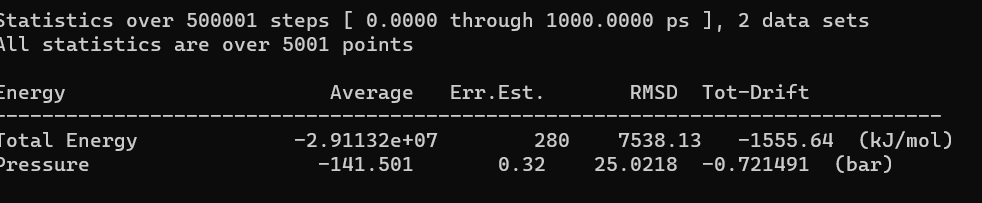

In [ ]:
#copy the topology file

In [3]:
%cp a1101_water.top a1101_water_after_npt.top

# Step 12: Production run : Triplicates

## Create md.mdp file
Obtain sample md.mdp file from http://www.mdtutorials.com/gmx/lysozyme/
### .mdp changes :
- change 1ns to 100 in comments
- replace from vdw type with what we did previously for npt.mdp


In [19]:
%cp md_6id4.mdp a1101_md.mdp

In [21]:
%mv a1101_md.mdp a1101_water_md.mdp

In [ ]:
vi a1101_water_md.mdp

# Generate the md.tpr file


gmx_mpi grompp -f a1101_water_md.mdp -c a1101_npt_24_05.gro  -r a1101_npt_24_05.gro -p a1101_water.top -o a1101_md.tpr -n a1101_water_post_em.ndx

## Batch script for MD run:

### Replicate 1 :

sbatch --mem=200G --time=96:00:00 -c 12 --gpus=v100:1 --wrap="gmx_mpi mdrun -deffnm a1101_repli1 -s a1101_md.tpr -nb gpu -ntomp 12"

### Replicate 2:
sbatch --mem=200G --time=96:00:00 -c 12 --gpus=v100:1 --wrap="gmx_mpi mdrun -deffnm a1101_repli2 -s a1101_md.tpr -nb gpu -ntomp 12"

### Replicate 3: 

sbatch --mem=200G --time=96:00:00 -c 12 --gpus=v100:1 --wrap="gmx_mpi mdrun -deffnm a1101_repli3 -s a1101_md.tpr -nb gpu -ntomp 12"